# Import Libraries

In [1]:
#pip list
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,KFold

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import optuna
from warnings import filterwarnings
filterwarnings('ignore')

from colorama import Style, Fore

from sklearn.metrics import mean_squared_log_error

TARGET = 'cost'

# Load the Dataset

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv', index_col = 'id')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv', index_col = 'id')
submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')
og = pd.read_csv('/kaggle/input/media-campaign-cost-prediction/train_dataset.csv')

display(train.head())
display(test.head())
display(submission.head())
display(og.head())

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
id,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist
id,,,,,,,,,,,,,,,
360336,7.24,4.0,1.0,0.0,2.0,10.80,0.0,1.0,7.0,20319.0,0.0,0.0,0.0,0.0,0.0
360337,6.90,2.0,2.0,2.0,3.0,8.51,1.0,0.0,4.0,33858.0,1.0,0.0,1.0,1.0,1.0
360338,8.34,3.0,0.0,0.0,3.0,8.77,0.0,1.0,14.0,39696.0,0.0,0.0,1.0,1.0,0.0
360339,5.48,2.0,3.0,3.0,2.0,21.90,1.0,0.0,9.0,23688.0,1.0,1.0,1.0,1.0,1.0
360340,4.80,3.0,2.0,0.0,2.0,10.90,1.0,0.0,11.0,27694.0,1.0,1.0,1.0,1.0,1.0


,id,cost
0,360336,99.615
1,360337,99.615
2,360338,99.615
3,360339,99.615
4,360340,99.615


,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,2.68,2.0,1.0,0.0,2.0,6.30,1.0,0.0,22.0,30584.0,1.0,1.0,1.0,1.0,1.0,79.59
1,5.73,3.0,5.0,5.0,3.0,18.70,1.0,0.0,30.0,20319.0,0.0,0.0,0.0,0.0,0.0,118.36
2,2.62,2.0,1.0,1.0,1.0,9.21,0.0,0.0,9.0,20319.0,0.0,0.0,0.0,0.0,0.0,67.20
3,11.73,3.0,1.0,1.0,3.0,10.90,1.0,1.0,15.0,23112.0,1.0,1.0,1.0,1.0,1.0,60.87
4,4.82,2.0,1.0,1.0,3.0,8.15,0.0,0.0,7.0,38382.0,0.0,0.0,0.0,0.0,0.0,86.79


# Sketch

In [3]:
train_features = [
    'total_children',
    'num_children_at_home',
    'avg_cars_at home(approx).1',
    'low_fat',
    'store_sqft',
    'coffee_bar',
    'video_store',
    'prepared_food',
    'florist',
    'cost'
]

test_features = [
    'total_children',
    'num_children_at_home',
    'avg_cars_at home(approx).1',
    'low_fat',
    'store_sqft',
    'coffee_bar',
    'video_store',
    'prepared_food',
    'florist'
]

train_cp = train[train_features]
test_cp = test[test_features]

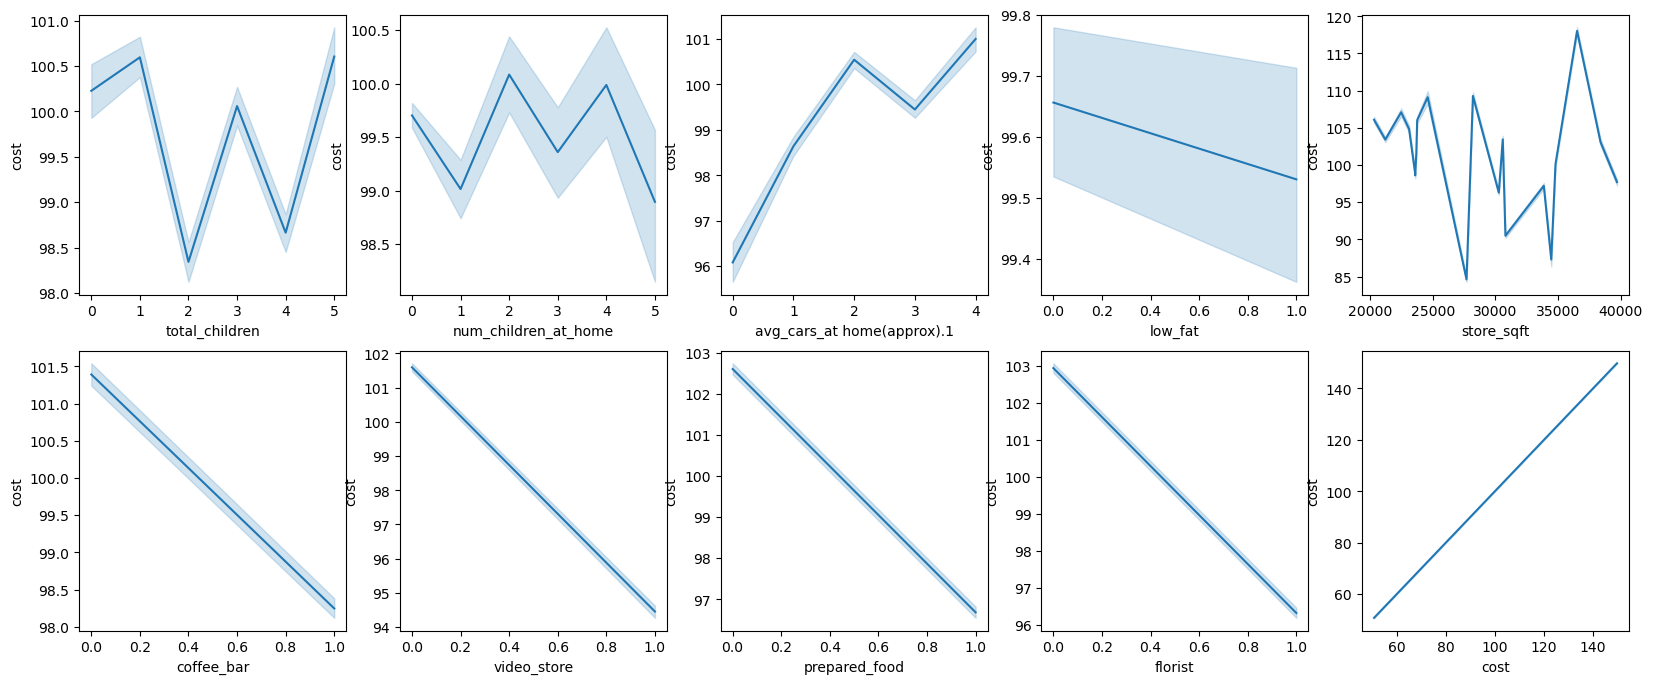

In [4]:
plt.figure(figsize = (20, 8))
for i, feature in enumerate(train_features):
    plt.subplot(2, 5, i + 1)
    sns.lineplot(x = train[feature], y = train['cost'])

<AxesSubplot:xlabel='avg_cars_at home(approx).1', ylabel='cost'>

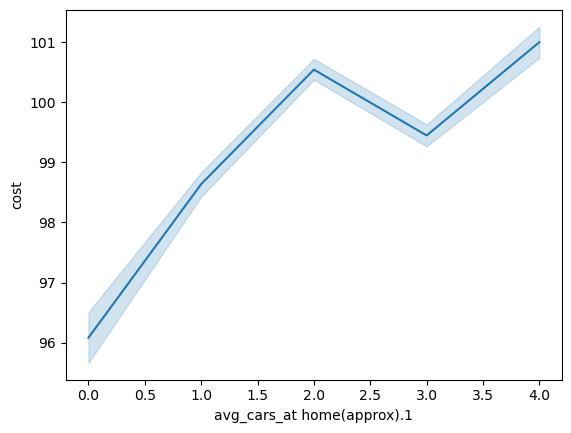

In [5]:
sns.lineplot(data = train, x = train['avg_cars_at home(approx).1'], y = train['cost'])

# Metadata

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Media Campaign Cost Prediction dataset. Our task is to predict the cost of media campaigns in the food marts on the basis of the features provided.

**Food Mart (CFM)** is a chain of convenience stores in the United States. The private company's headquarters are located in Mentor, Ohio, and currently, approximately 325 stores are located in the US. Convenient Food Mart operates on the franchise basis.

There are 15 independent variables (including id):

store_sales: Store sales in millions.

unit_sales: Quantity of units sold.

total_children: Total children in home.

num_children_at_home: Total children at home as per customer filled details.

avg_cars_at_home: Average cars at home.

gross_weight: Gross weight of an item.

recyclable_package: If the package of the food item is recycleble 1 or not 0.

low_fat: If an item is a low fat 1 or not 0.

units_per_case: Units/case units available in each store shelves.

store_sqft: Store area available in sqft.

coffee_bar: If a store has a coffee bar available 1 or not 0.

video_store: If a video store/gaming store is available 1 or not 0.

salad_bar: if a salad bar is available in a store 1 or not 0.

prepared_food: if a prepared food is available in a store 1 or not 0.

florist: if flower shelves are available in a store 1 or not 0.

Target variable: cost: Cost on acquiring a customers in dollars.

Metrics: RMSLE(the sklearn mean_squared_log_error with squared=False).

# Null Values check

In [6]:
print(train.isnull().sum().sum(), test.isnull().sum().sum())

0 0


# Know your data

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
store_sales(in millions),360336.0,6.337376,3.307980,0.51,3.72,5.78,8.40,22.92
unit_sales(in millions),360336.0,3.043881,0.784676,1.00,3.00,3.00,4.00,6.00
total_children,360336.0,2.456482,1.488992,0.00,1.00,2.00,4.00,5.00
num_children_at_home,360336.0,0.689390,1.214732,0.00,0.00,0.00,1.00,5.00
avg_cars_at home(approx).1,360336.0,2.203813,1.084293,0.00,1.00,2.00,3.00,4.00
gross_weight,360336.0,13.822071,4.614792,6.00,9.71,13.60,17.70,21.90
recyclable_package,360336.0,0.568086,0.495343,0.00,0.00,1.00,1.00,1.00
low_fat,360336.0,0.327797,0.469411,0.00,0.00,0.00,1.00,1.00
units_per_case,360336.0,18.972706,10.212912,1.00,10.00,20.00,28.00,36.00
store_sqft,360336.0,28180.333442,5968.874074,20319.00,23593.00,27694.00,33858.00,39696.00


In [8]:
print(f'Length of the data {train.shape[0]}')
for col in train.columns:
    print(f'{col} : {train[col].nunique()}')

Length of the data 360336
store_sales(in millions) : 1044
unit_sales(in millions) : 6
total_children : 6
num_children_at_home : 6
avg_cars_at home(approx).1 : 5
gross_weight : 384
recyclable_package : 2
low_fat : 2
units_per_case : 36
store_sqft : 20
coffee_bar : 2
video_store : 2
salad_bar : 2
prepared_food : 2
florist : 2
cost : 328


**Insights**

- Even though the data is huge, maximum number of unique values is 1044 for -> store sales
- There are some categorical features with unique values less than 40

In [9]:
categorical_features = ['unit_sales(in millions)','total_children','num_children_at_home','low_fat','avg_cars_at home(approx).1','recyclable_package','units_per_case','coffee_bar','video_store','salad_bar','prepared_food','florist']
continuous_features = ['store_sales(in millions)','gross_weight','units_per_case']

# Exploratory Data Analysis

array([[<AxesSubplot:title={'center':'store_sales(in millions)'}>,
        <AxesSubplot:title={'center':'unit_sales(in millions)'}>,
        <AxesSubplot:title={'center':'total_children'}>,
        <AxesSubplot:title={'center':'num_children_at_home'}>],
       [<AxesSubplot:title={'center':'avg_cars_at home(approx).1'}>,
        <AxesSubplot:title={'center':'gross_weight'}>,
        <AxesSubplot:title={'center':'recyclable_package'}>,
        <AxesSubplot:title={'center':'low_fat'}>],
       [<AxesSubplot:title={'center':'units_per_case'}>,
        <AxesSubplot:title={'center':'store_sqft'}>,
        <AxesSubplot:title={'center':'coffee_bar'}>,
        <AxesSubplot:title={'center':'video_store'}>],
       [<AxesSubplot:title={'center':'salad_bar'}>,
        <AxesSubplot:title={'center':'prepared_food'}>,
        <AxesSubplot:title={'center':'florist'}>,
        <AxesSubplot:title={'center':'cost'}>]], dtype=object)

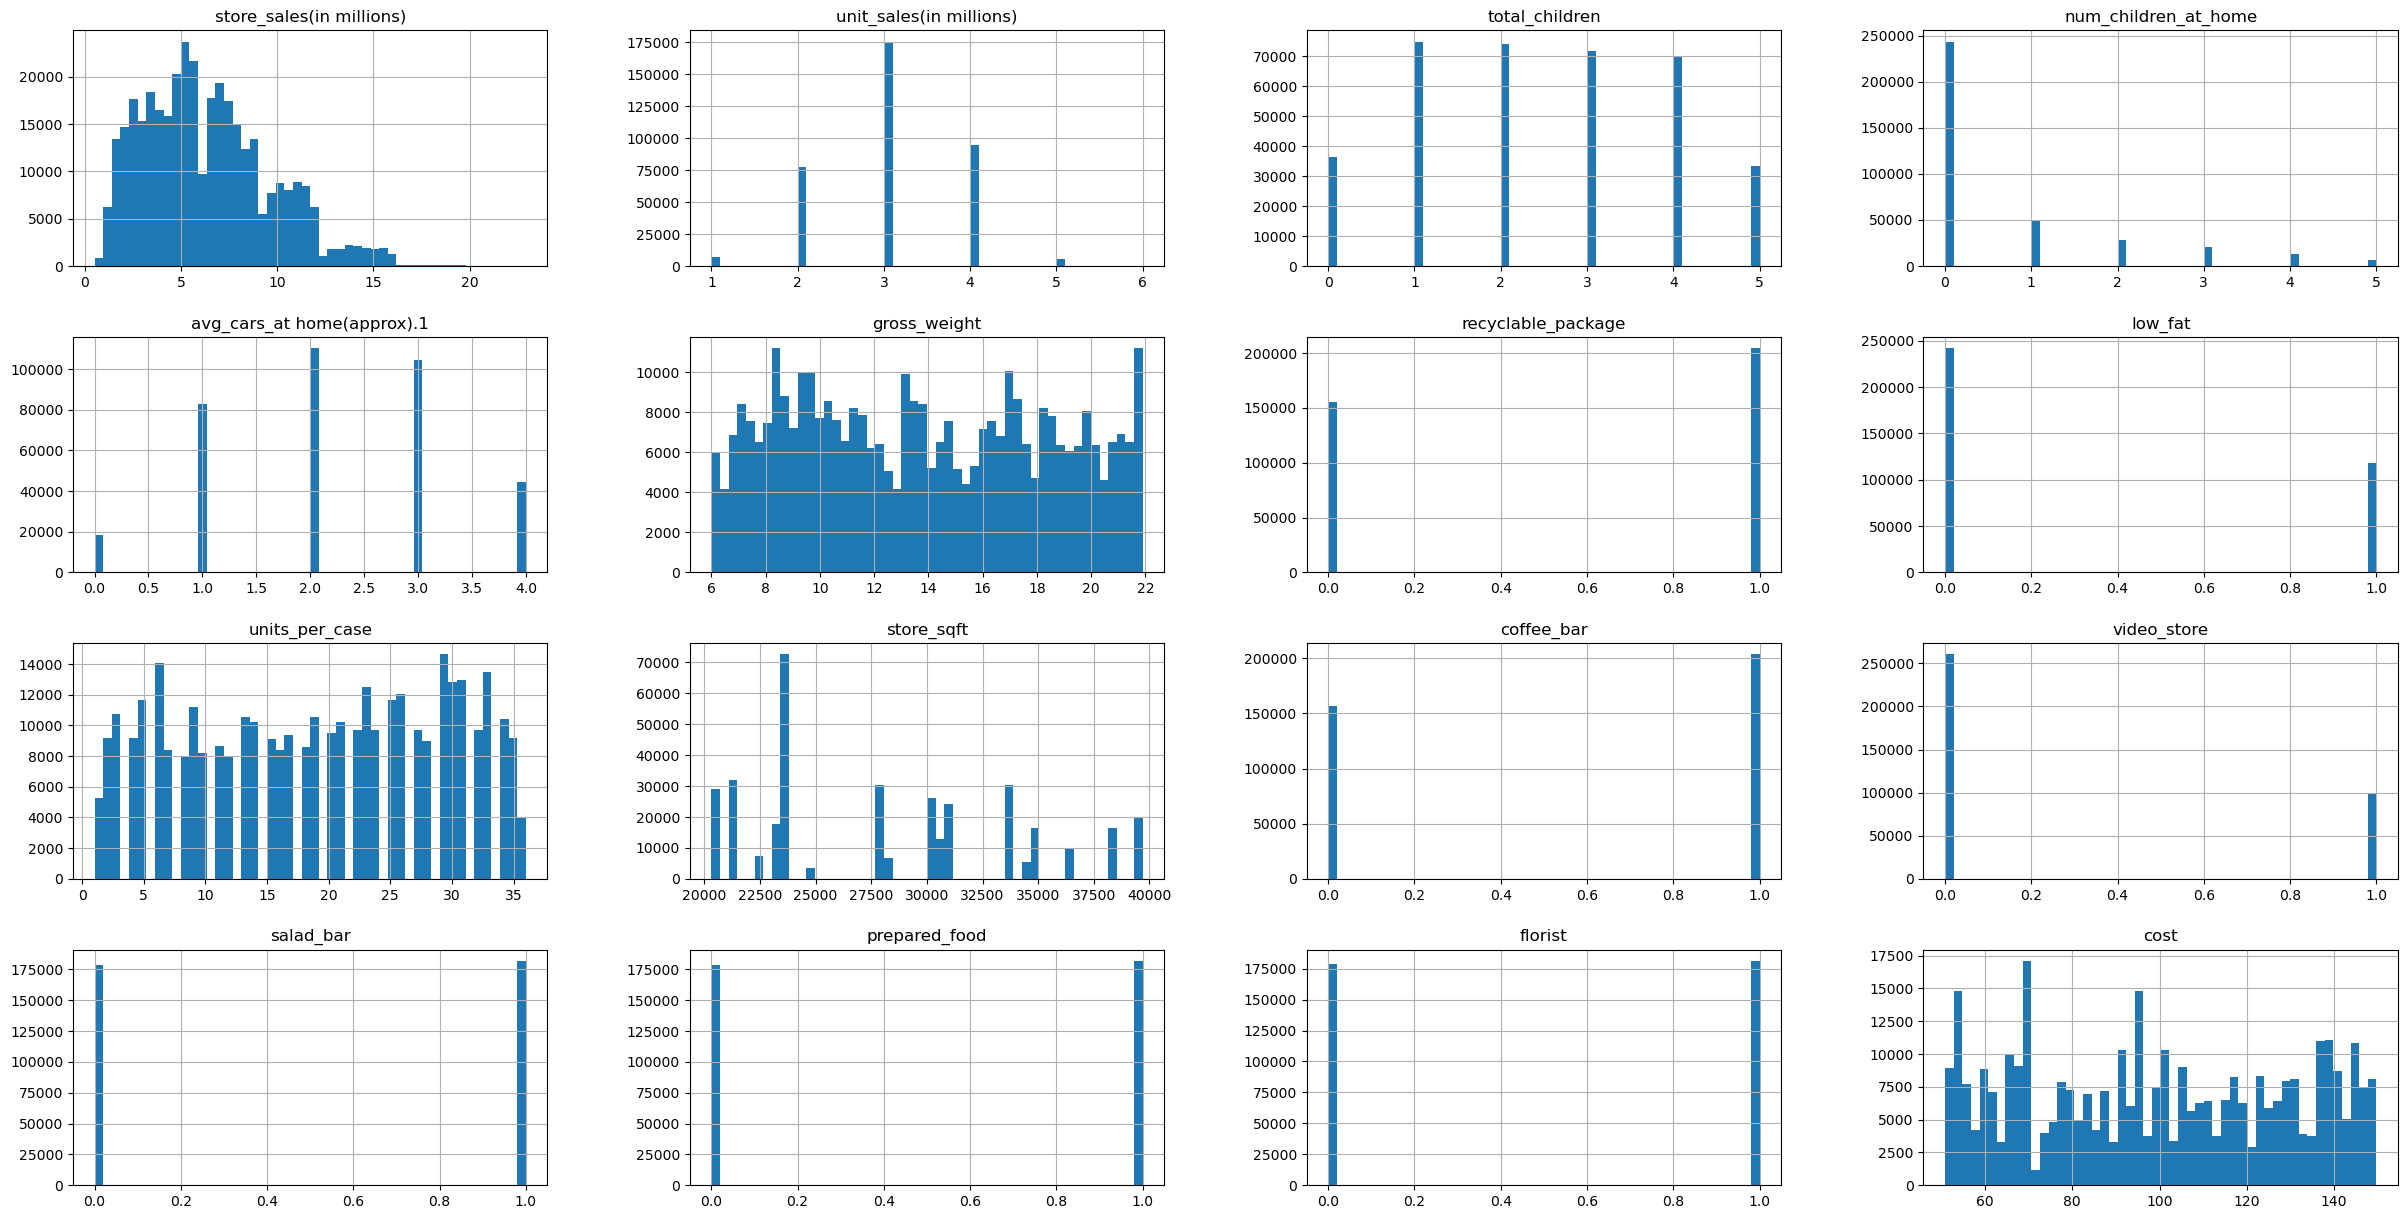

In [10]:
train.hist(bins = 50, figsize = (30, 15))

Text(0.5, 0.98, 'Countplots')

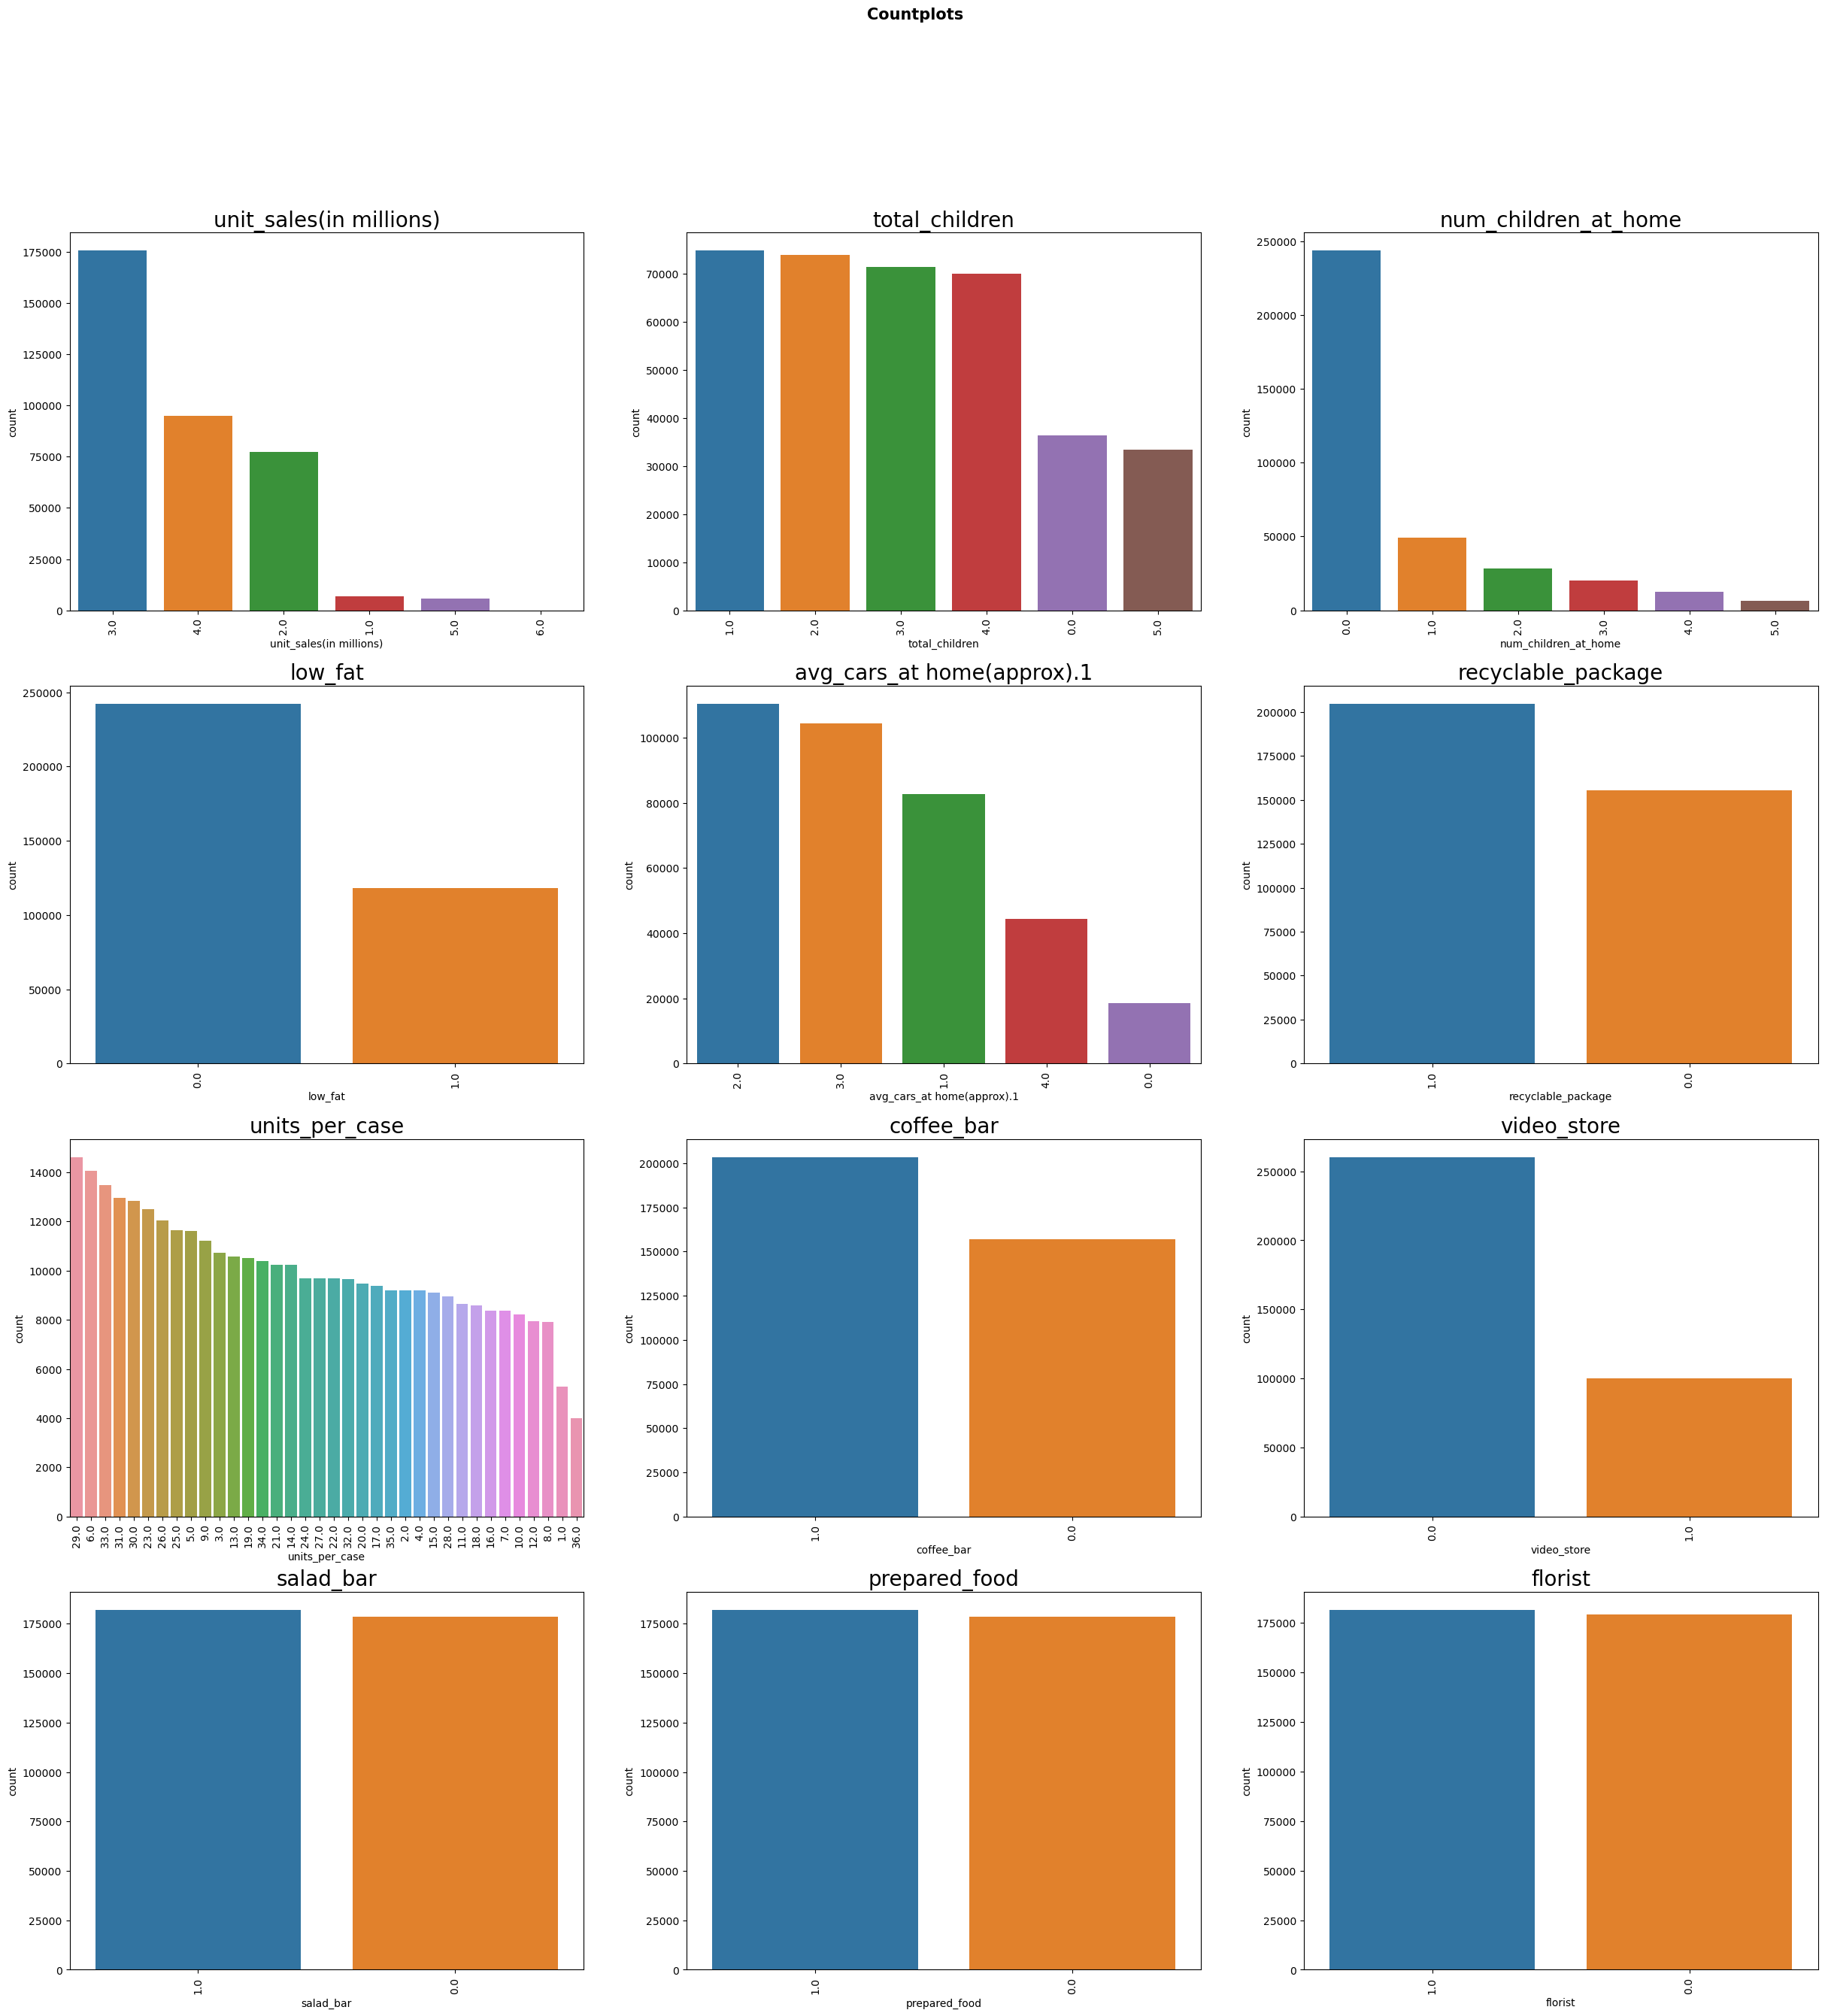

In [11]:
plt.figure(figsize = (30, 30))
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 3, i + 1)
    sns.countplot(data = train, x = feature, order = train[feature].value_counts().index)
    plt.xticks(rotation = 90)
    plt.title(feature, fontsize = 20)
plt.suptitle('Countplots', fontsize = 15, fontweight = 'bold')

**Insights**
- If you look at unit_sales column countplot(1st), count of 6 is negligible and might as well remove it from the distribution

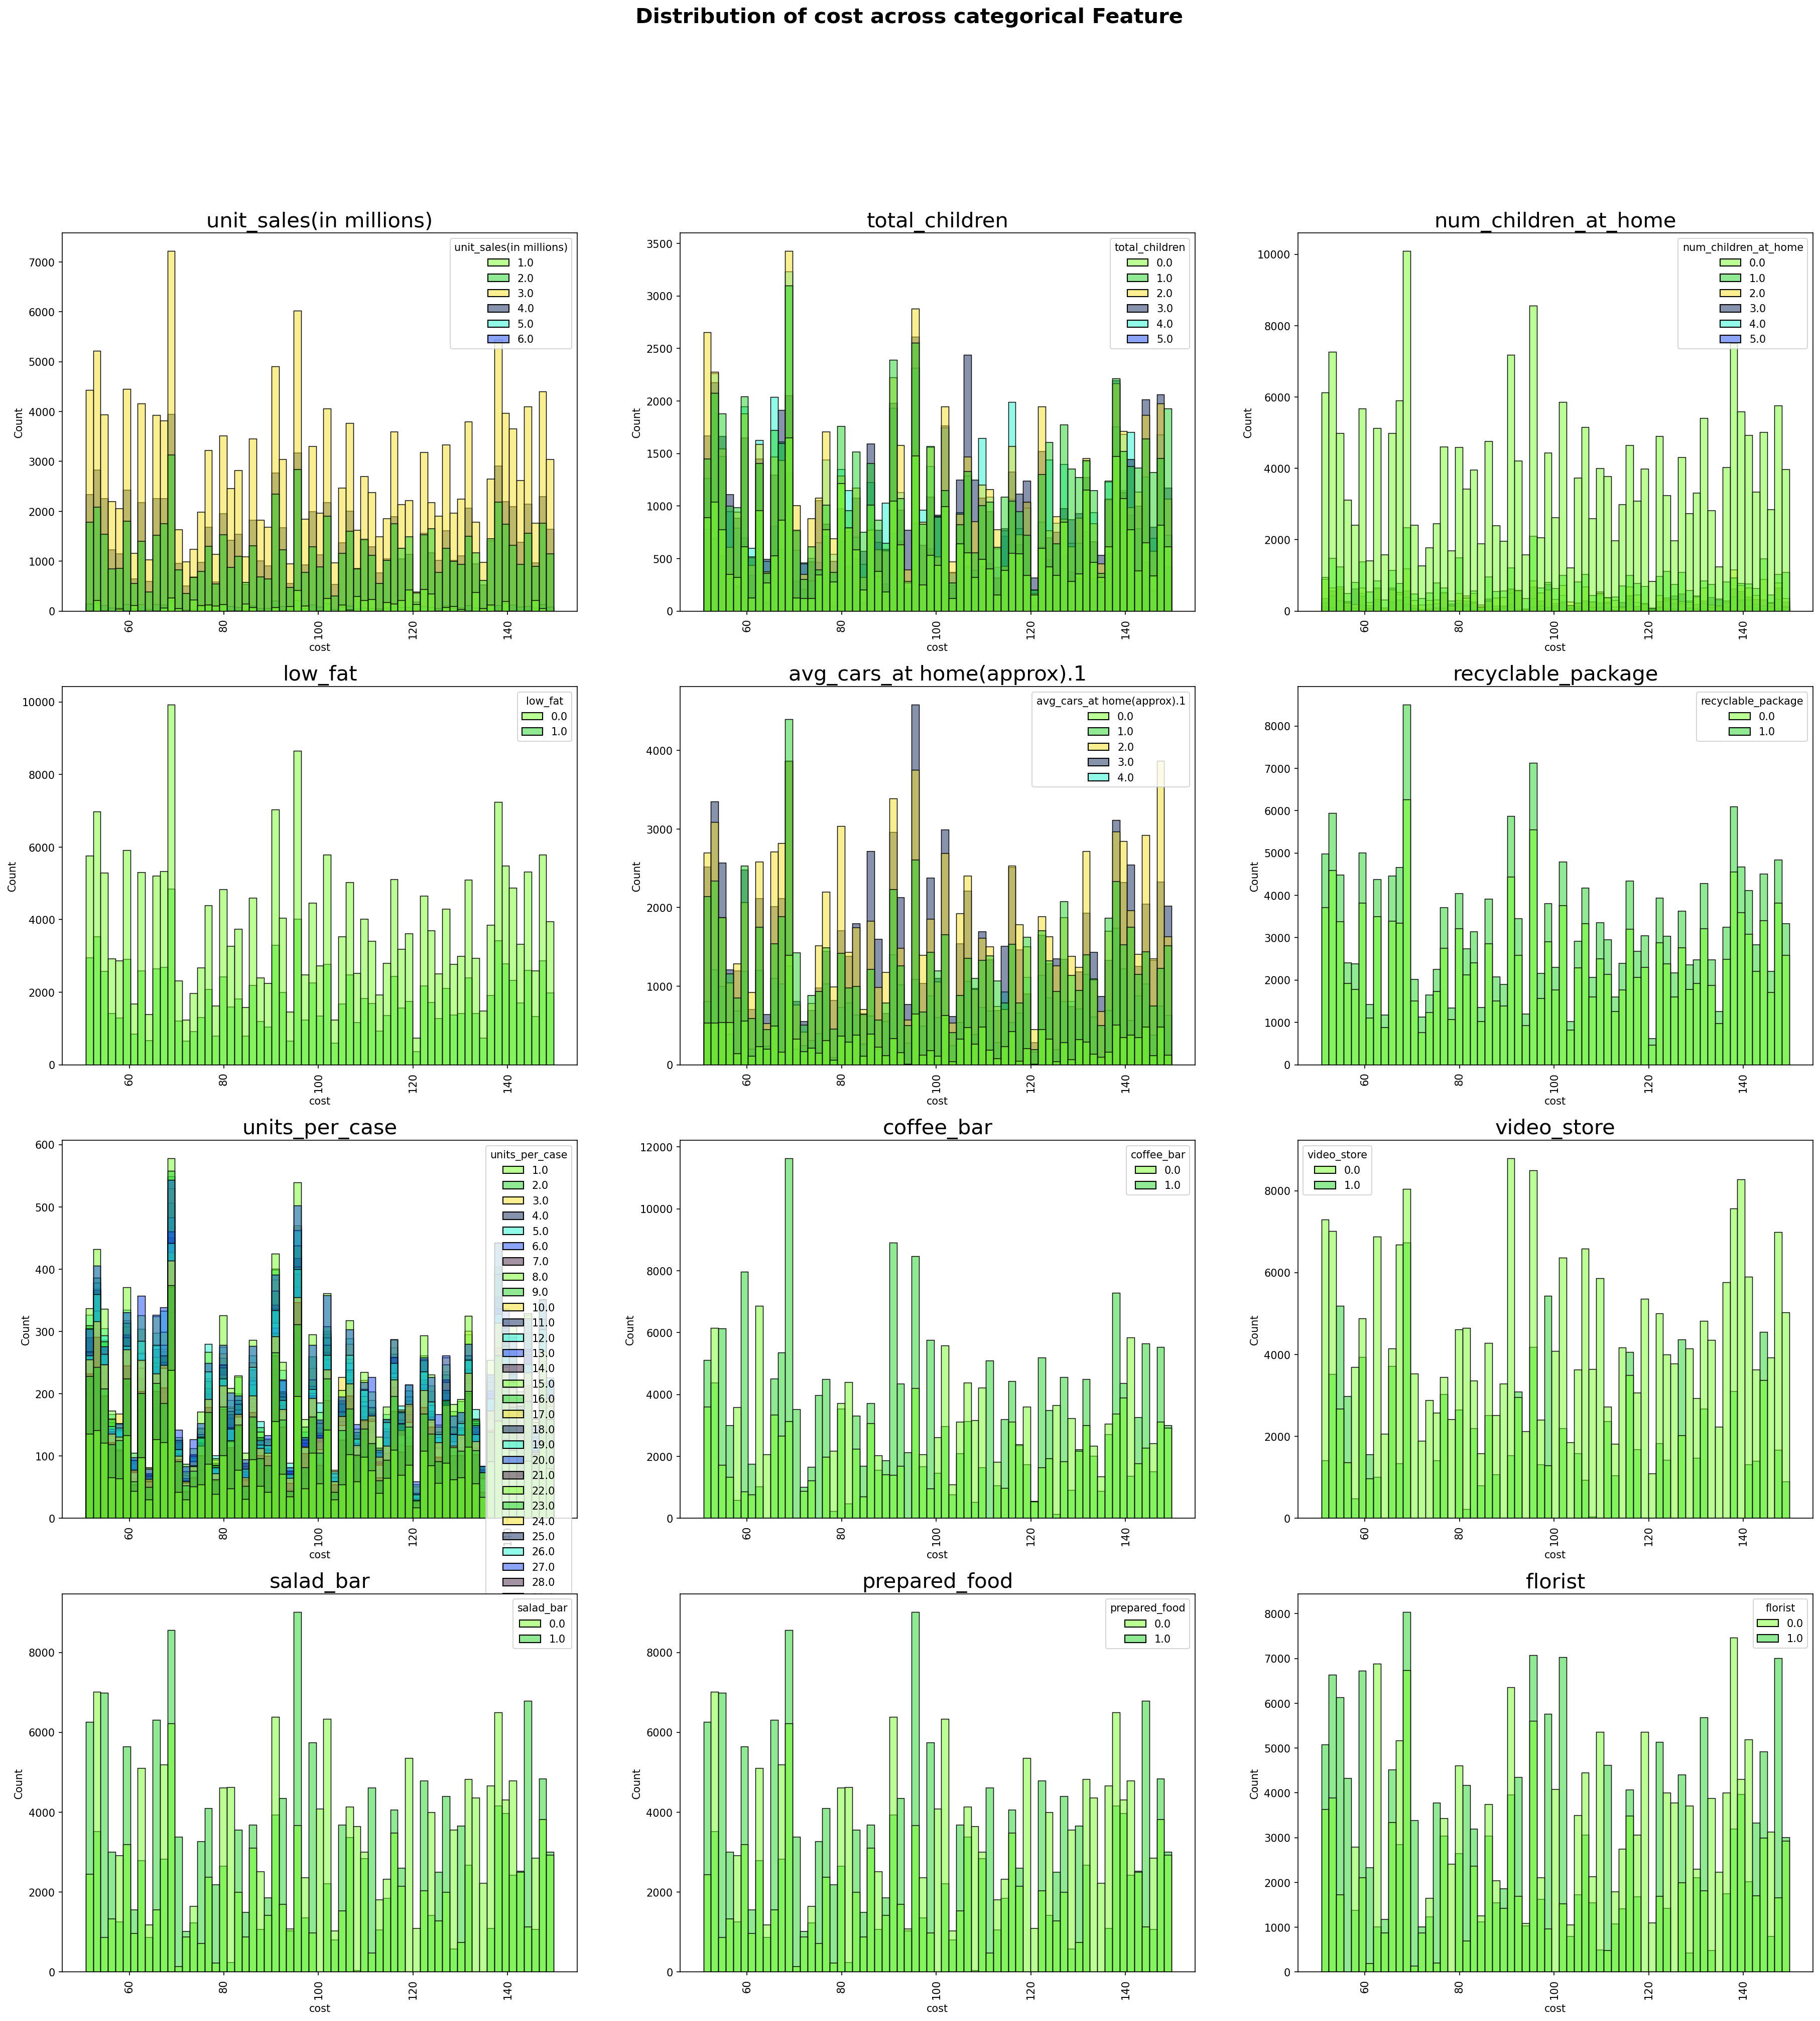

In [12]:
plt.figure(figsize = (30, 30), dpi = 150)
# binary_features = [col for col in train.columns if (train[col].nunique == 2)]
for i, feature in enumerate(categorical_features):
    plt.subplot(4, 3, i + 1)
    sns.histplot(data = train, x = 'cost', hue = feature, palette = ['#79ff2b','#22d429','#f5e025','#10295c','#25f5d2','#184af0','#4a2949'])
    plt.xticks(rotation = 90)
    plt.title(feature, fontsize = 20)
plt.suptitle('Distribution of cost across categorical Feature', fontweight = 'bold',fontsize = 20)
plt.show()

**Insights**
- Prepared Food and salad bar follow nearly same distribution, their count for 1's and 0's are also nearly same
- Their correlation factor is -1

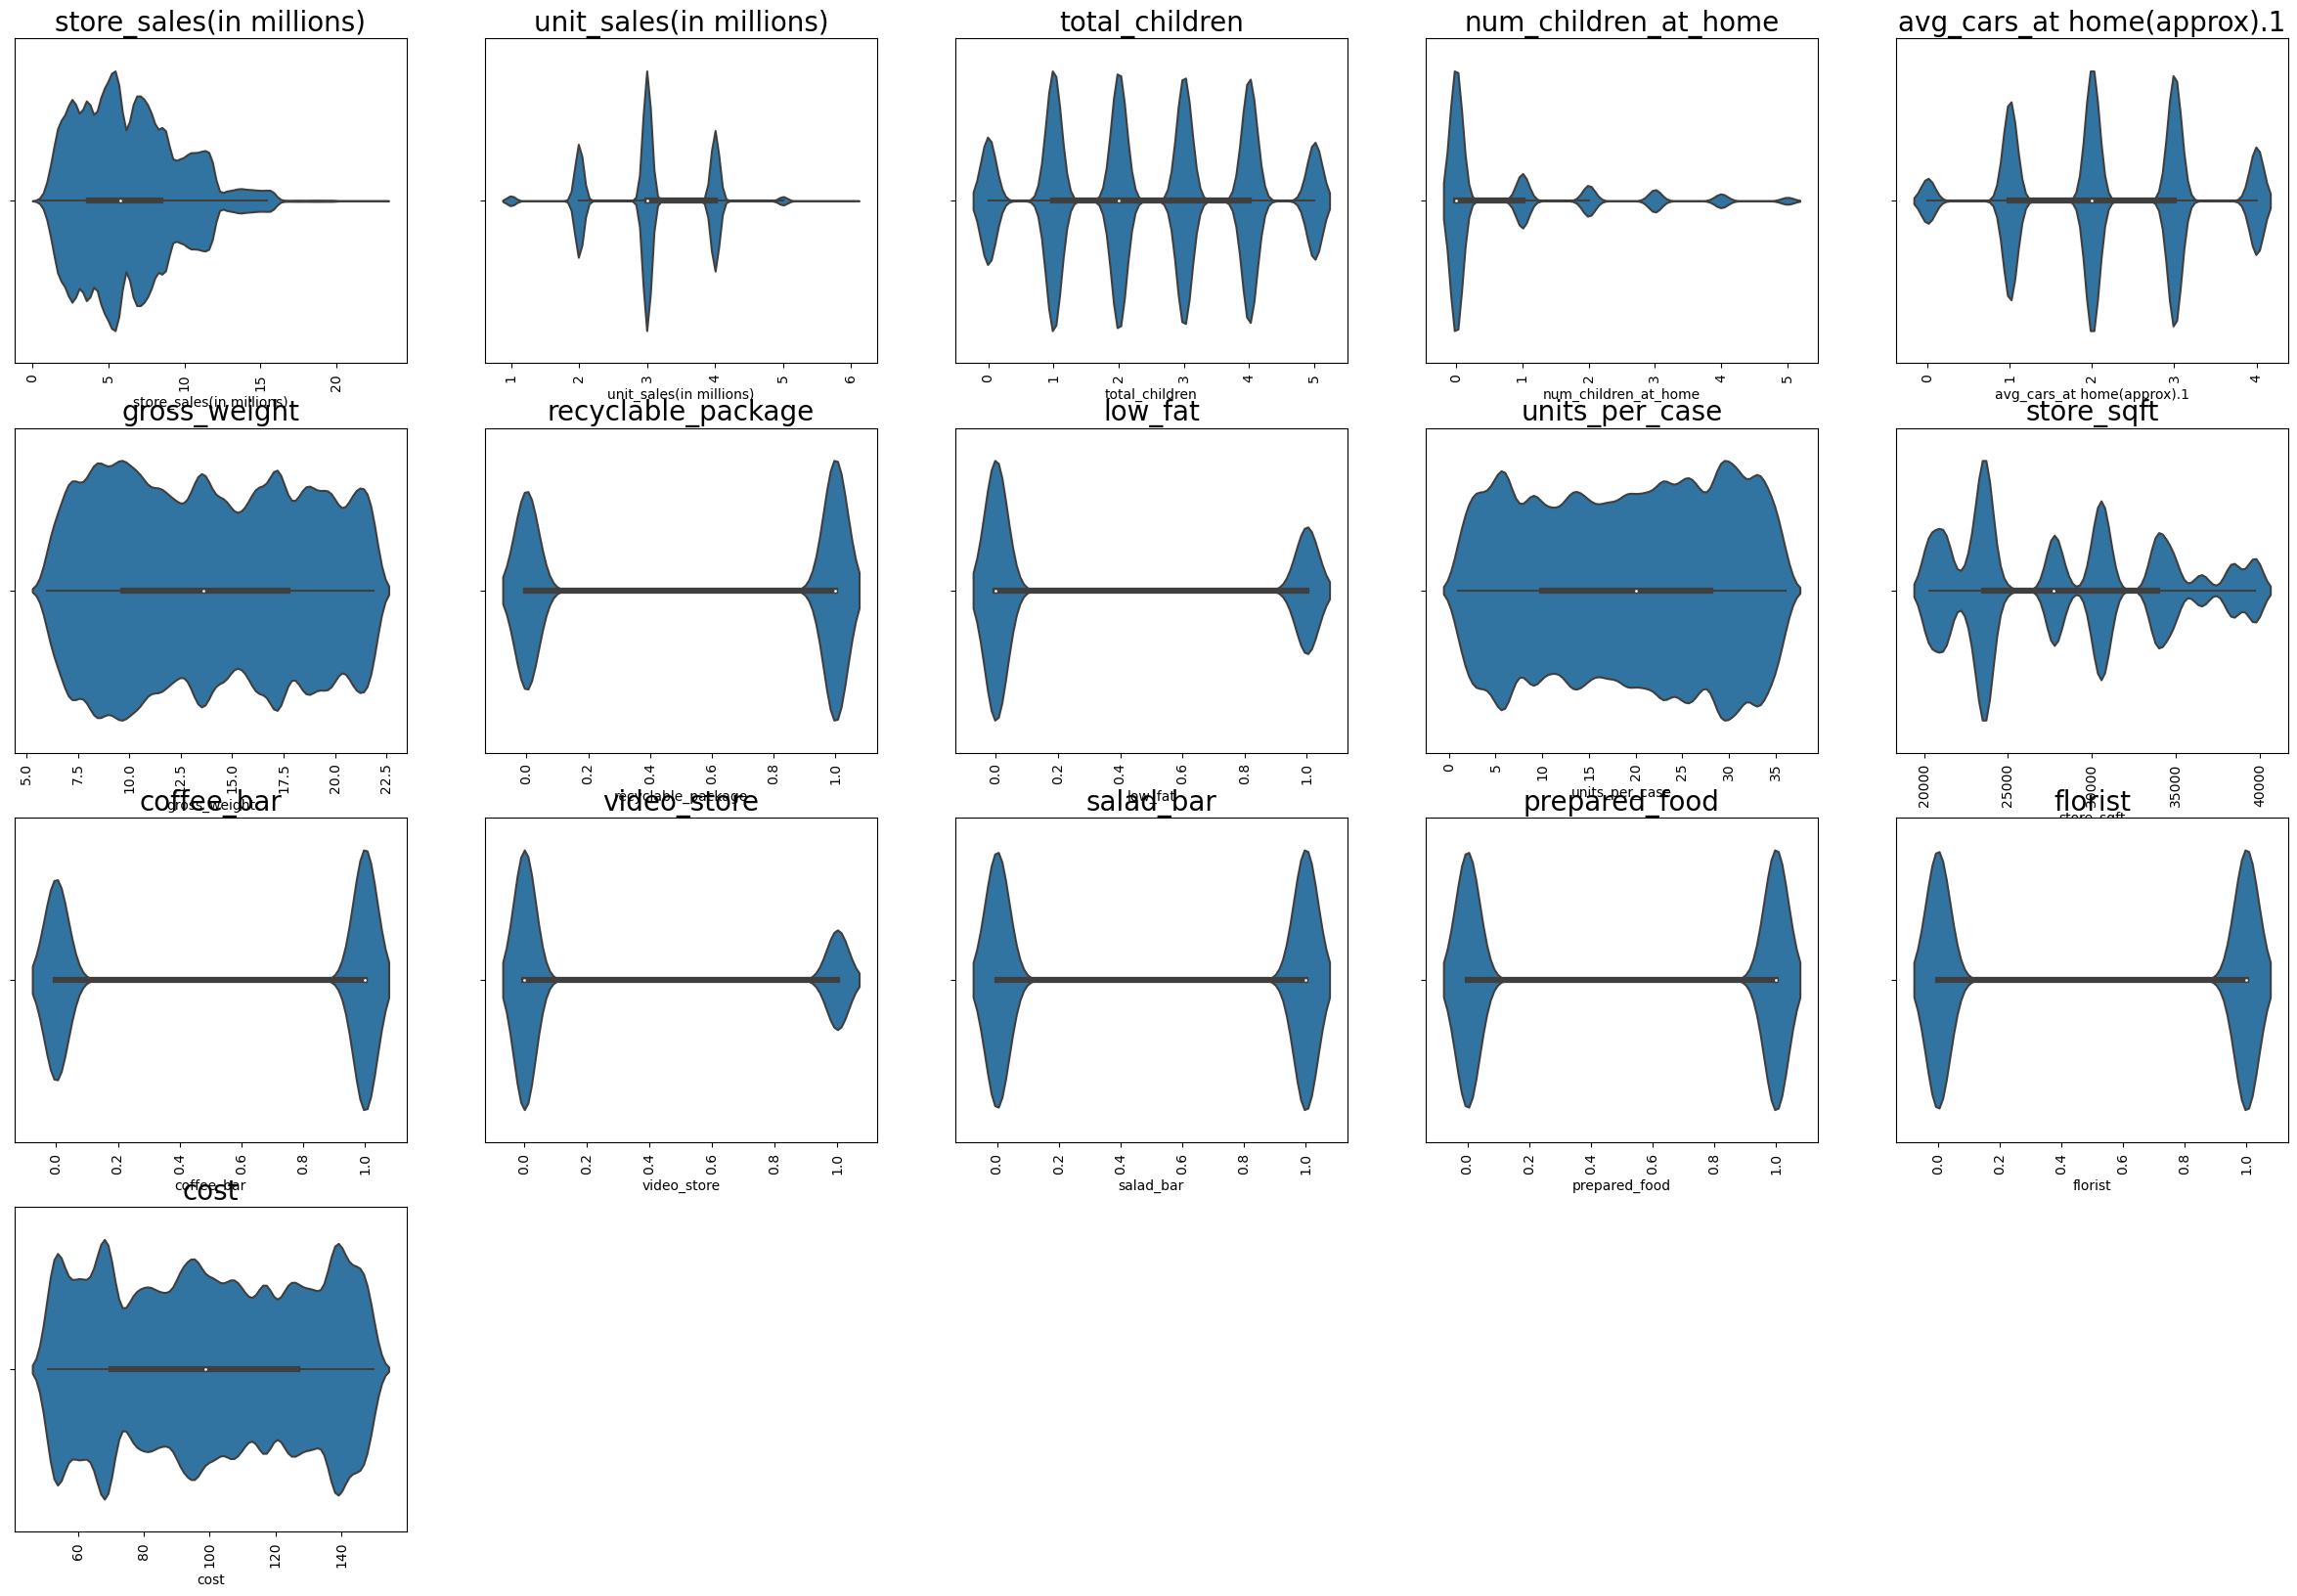

In [13]:
def violin(df):
    features = train.columns
    plt.figure(figsize = (30, 25))
    rows, columns = 5, 5
    for i in range(len(features)):
        plt.subplot(rows, columns, i + 1)
        sns.violinplot(data = df, x = features[i])
        plt.xticks(rotation = 90)
        plt.title(f'{features[i]}', fontsize = 20)
    plt.show()
    
violin(train)

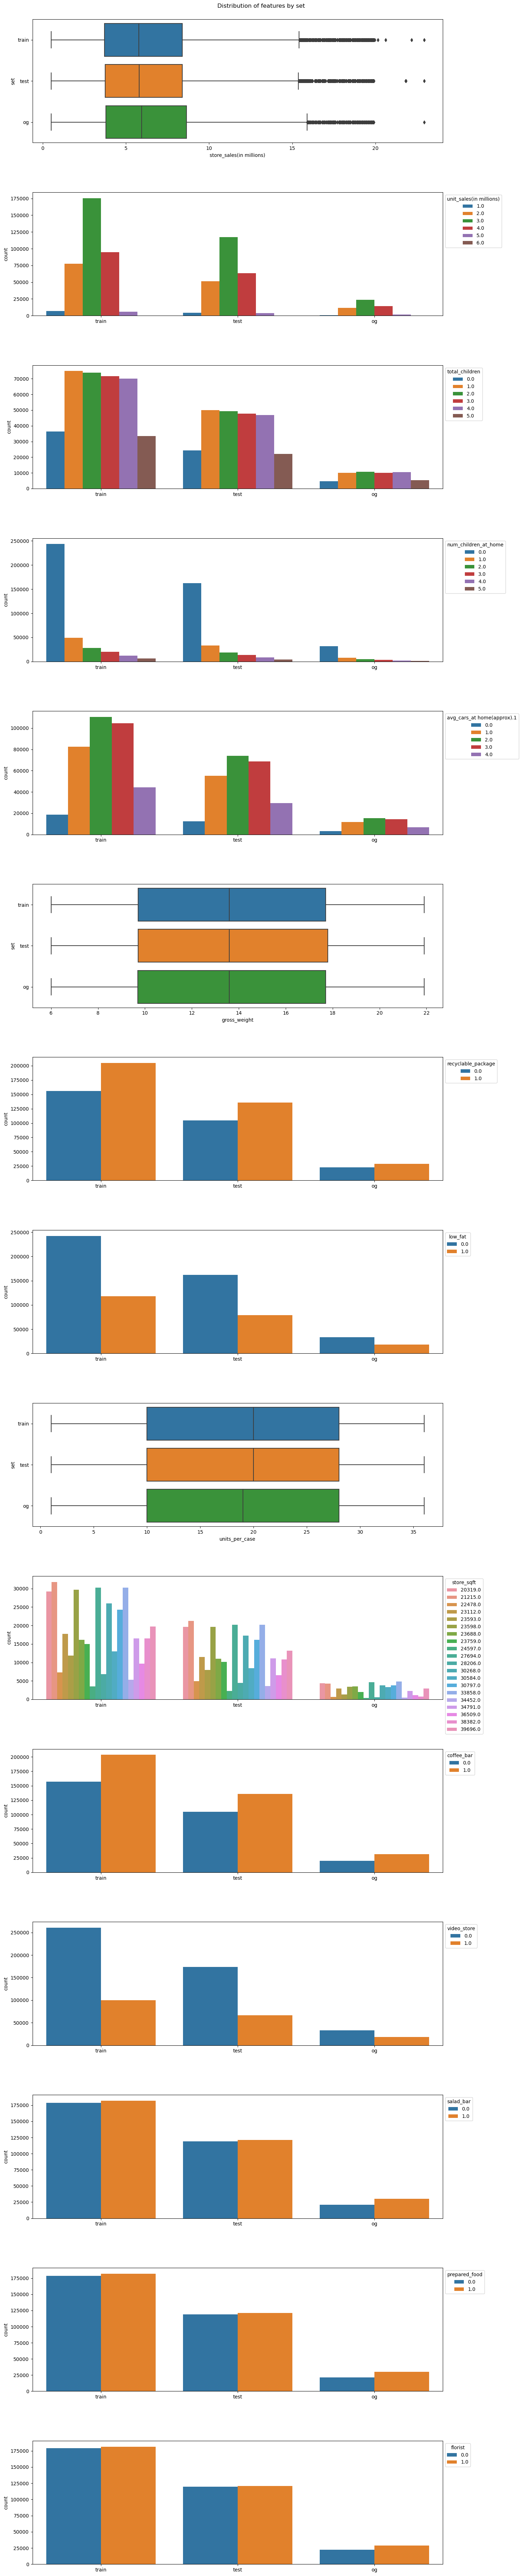

In [14]:
new_train = train.copy()
new_test = test.copy()
new_og = og.copy()
new_train['set'] = 'train'
new_test['set'] = 'test'
new_og['set'] = 'og'

df_combined = pd.concat([new_train, new_test, new_og])
NUM_FEATURES = [c for c in train.columns if c not in [TARGET, 'set']]
ncols = 1
nrows= np.ceil(len(NUM_FEATURES) / ncols).astype(int)
fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize = (15, nrows * 5))
for c, ax in zip(NUM_FEATURES, axs.flatten()):
    if df_combined[c].nunique() > 20:
        sns.boxplot(data = df_combined, x = c, ax = ax, y = 'set')
    else:
        sns.countplot(data = df_combined, x = 'set', ax = ax, hue = c)
        ax.legend(bbox_to_anchor = (1,1), loc = 'upper left', title = c)
        ax.set_xlabel('')
        
fig.suptitle("Distribution of features by set")
plt.tight_layout(rect = [0, 0, 1, 0.98])
for df in [train, test, og]:
    df.drop(columns = ['set'], errors = 'ignore')

**Insights**

- From histograms it is sure that training and testing set follow a very close distribution unlike their parent dataset

# Train - Test Overlap

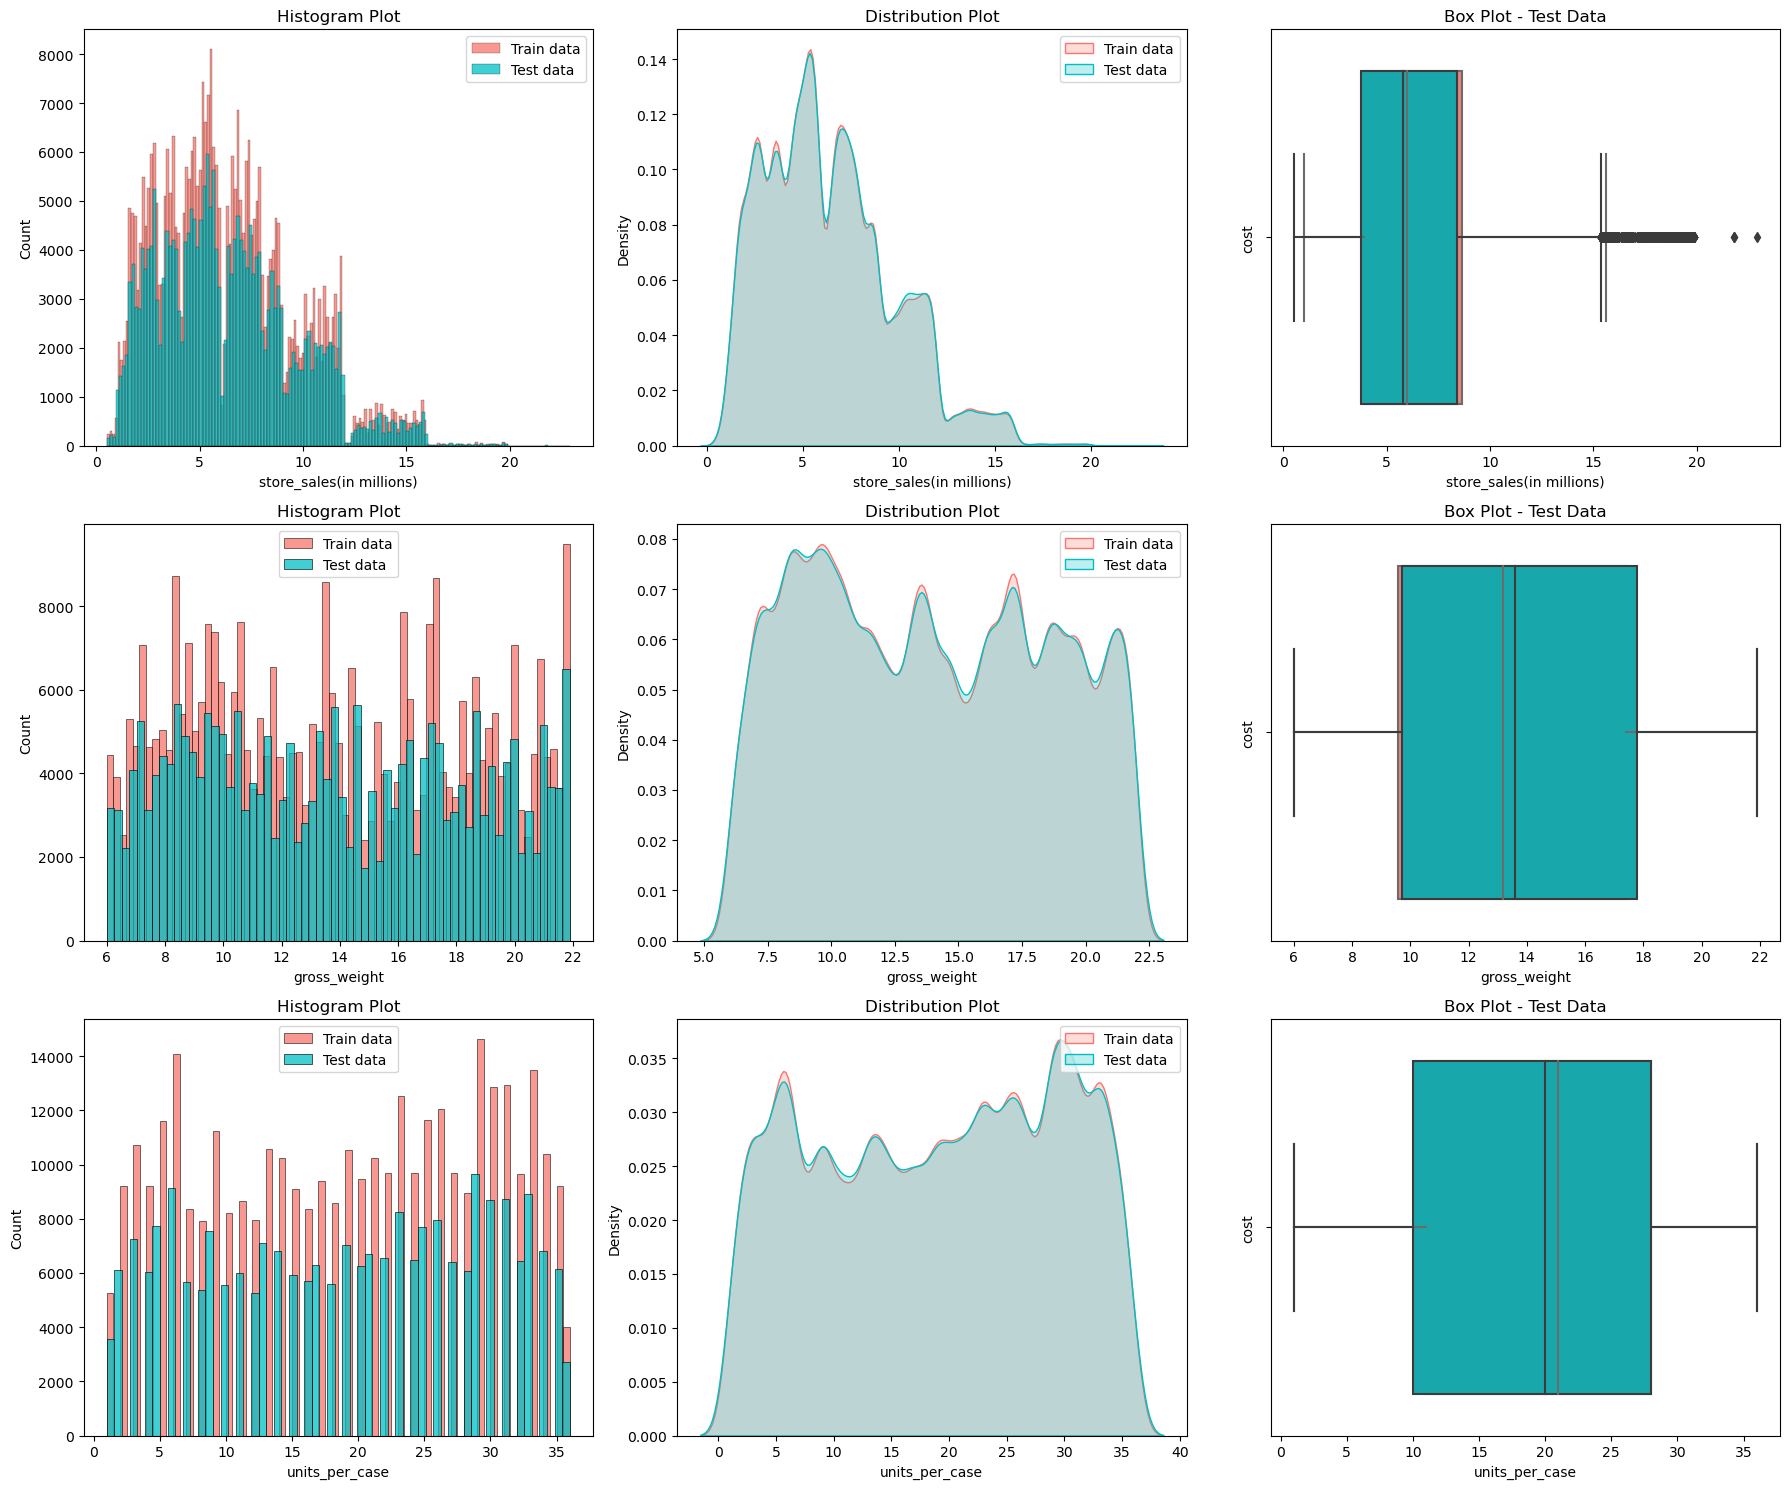

In [15]:
ncols = 3
nrows = len(continuous_features)

fig, axes = plt.subplots(nrows, ncols, figsize = (18, 5 * nrows))

for r in range(nrows):
    row = continuous_features[r]
    
    sns.histplot(x=train[row], ax=axes[r,0], color='#F8766D', label='Train data' , fill =True )
    sns.histplot(x=test[row], ax=axes[r,0], color='#00BFC4', label='Test data', fill =True)
    
    sns.kdeplot(x=train[row], ax=axes[r,1], color='#F8766D', label='Train data' , fill =True )
    sns.kdeplot(x=test[row], ax=axes[r,1], color='#00BFC4', label='Test data', fill =True)
    
    sns.boxplot(x=train[row], y = train['cost'], ax=axes[r,2], color='#F8766D', orient = "h")
    sns.boxplot(x=test[row], ax=axes[r,2], color='#00BFC4', orient = "h")
    
    axes[r,0].legend()
    axes[r,1].legend()
    axes[r,0].title.set_text("Histogram Plot")
    axes[r,1].title.set_text("Distribution Plot")
    axes[r,2].title.set_text("Box Plot - Train Data")
    axes[r,2].title.set_text("Box Plot - Test Data")
fig.tight_layout()
plt.show()

# Feature Correlations

In [16]:
# correlation = pd.concat([x,y], axis = 1)
corr = train.corr()

In [17]:
def highlighter(cell_value):
    if(cell_value >= 0.7) & (cell_value != 1):
        return "background-color: green"
corr.style.applymap(highlighter)

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
store_sales(in millions),1.000000,0.481376,0.069303,0.029261,0.006794,0.038159,0.030390,-0.008735,-0.009893,0.021572,-0.040039,0.029564,0.044832,0.044854,0.046472,-0.012387
unit_sales(in millions),0.481376,1.000000,0.113231,0.046755,0.017119,0.000467,0.001074,-0.003663,0.001141,0.045540,-0.076967,0.053795,0.082445,0.082485,0.083062,-0.026509
total_children,0.069303,0.113231,1.000000,0.359207,0.078519,-0.000908,0.002236,-0.001597,-0.000267,-0.008991,-0.006476,-0.013303,-0.023564,-0.023560,-0.012545,-0.007482
num_children_at_home,0.029261,0.046755,0.359207,1.000000,0.115476,-0.000601,0.006104,-0.000208,-0.004174,0.005785,-0.023234,-0.020738,-0.031109,-0.031050,-0.017888,-0.001727
avg_cars_at home(approx).1,0.006794,0.017119,0.078519,0.115476,1.000000,-0.002267,0.004021,-0.001912,0.001190,-0.020032,-0.000441,0.012702,-0.013102,-0.013035,-0.004284,0.027098
gross_weight,0.038159,0.000467,-0.000908,-0.000601,-0.002267,1.000000,0.059050,-0.033421,-0.017609,-0.000455,0.000835,-0.000845,0.002116,0.002155,0.000764,-0.000116
recyclable_package,0.030390,0.001074,0.002236,0.006104,0.004021,0.059050,1.000000,-0.030025,-0.003028,-0.000343,0.004037,0.004129,0.004674,0.004672,0.004849,-0.001455
low_fat,-0.008735,-0.003663,-0.001597,-0.000208,-0.001912,-0.033421,-0.030025,1.000000,0.030226,0.001972,0.002622,0.002893,0.005602,0.005567,0.005540,-0.001975
units_per_case,-0.009893,0.001141,-0.000267,-0.004174,0.001190,-0.017609,-0.003028,0.030226,1.000000,0.002297,0.000828,0.000569,0.001698,0.001699,0.000556,0.000180
store_sqft,0.021572,0.045540,-0.008991,0.005785,-0.020032,-0.000455,-0.000343,0.001972,0.002297,1.000000,-0.198243,-0.083873,0.333055,0.333102,-0.074157,-0.049201


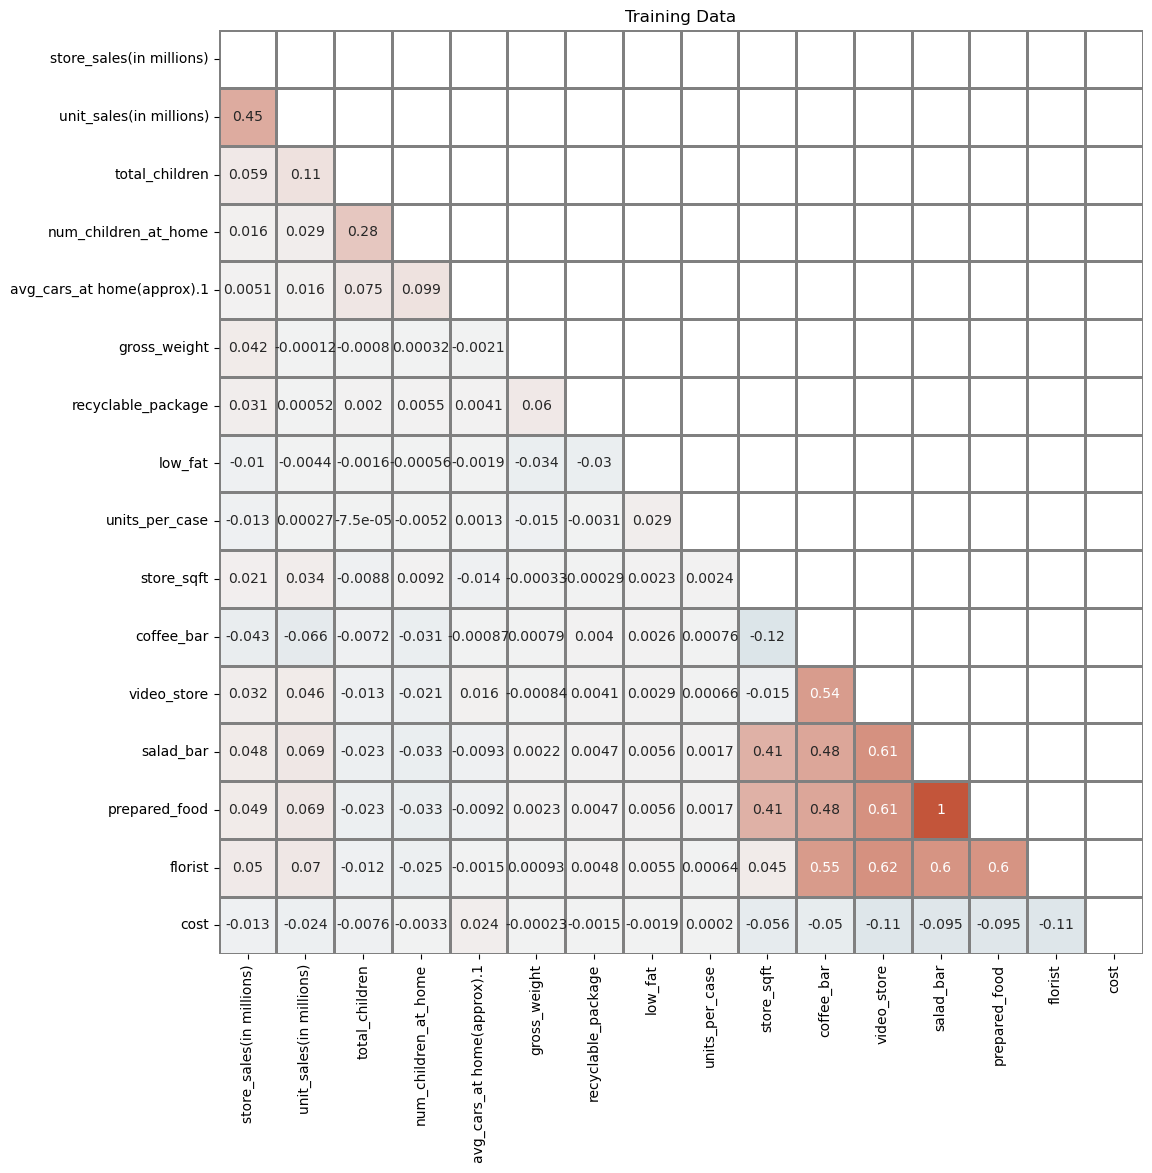

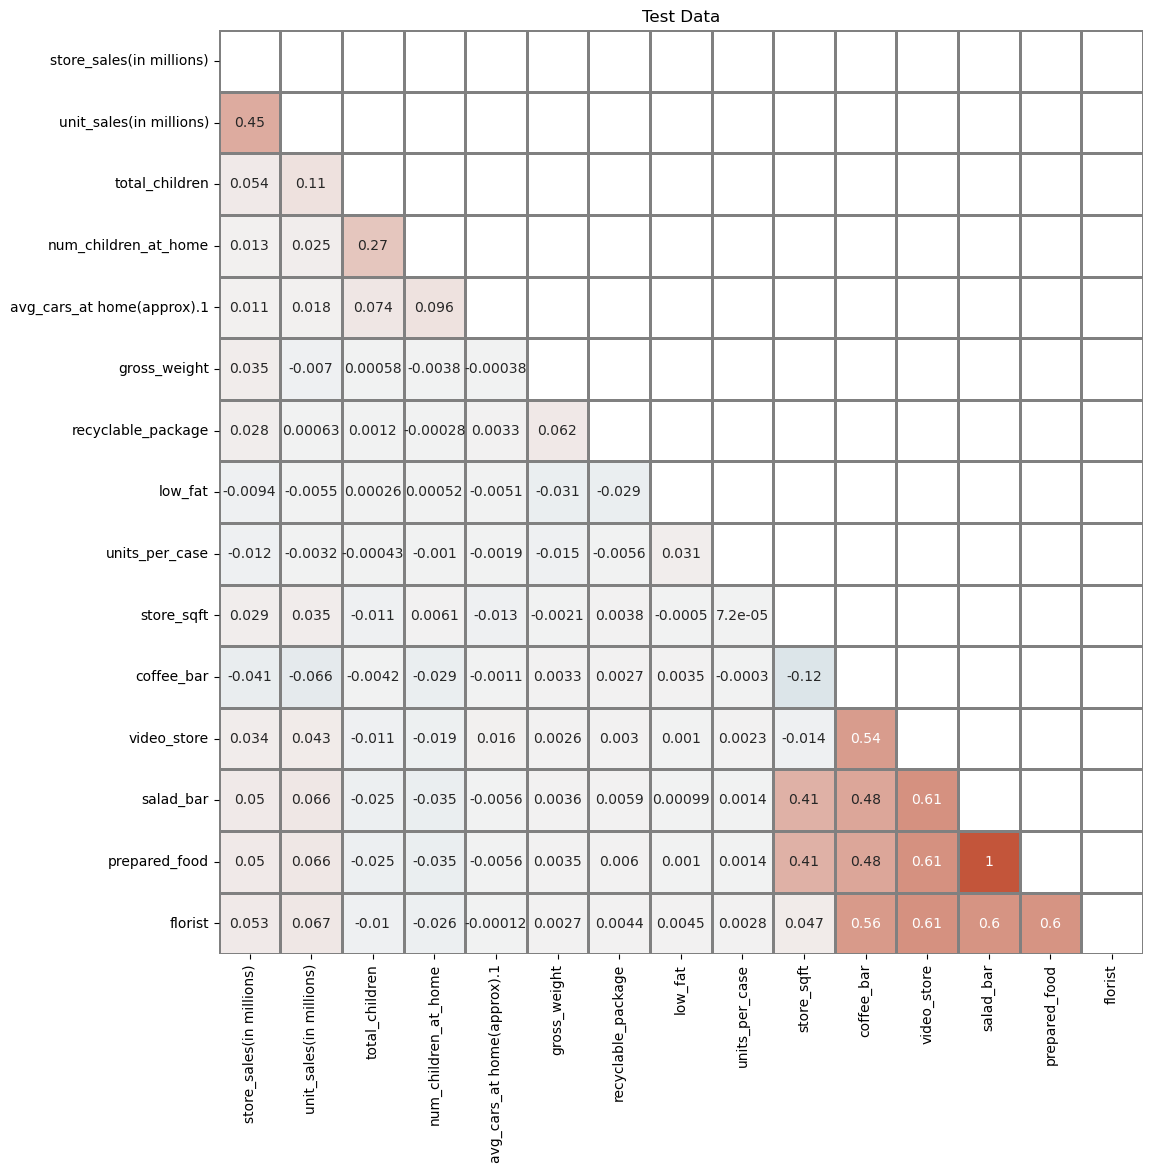

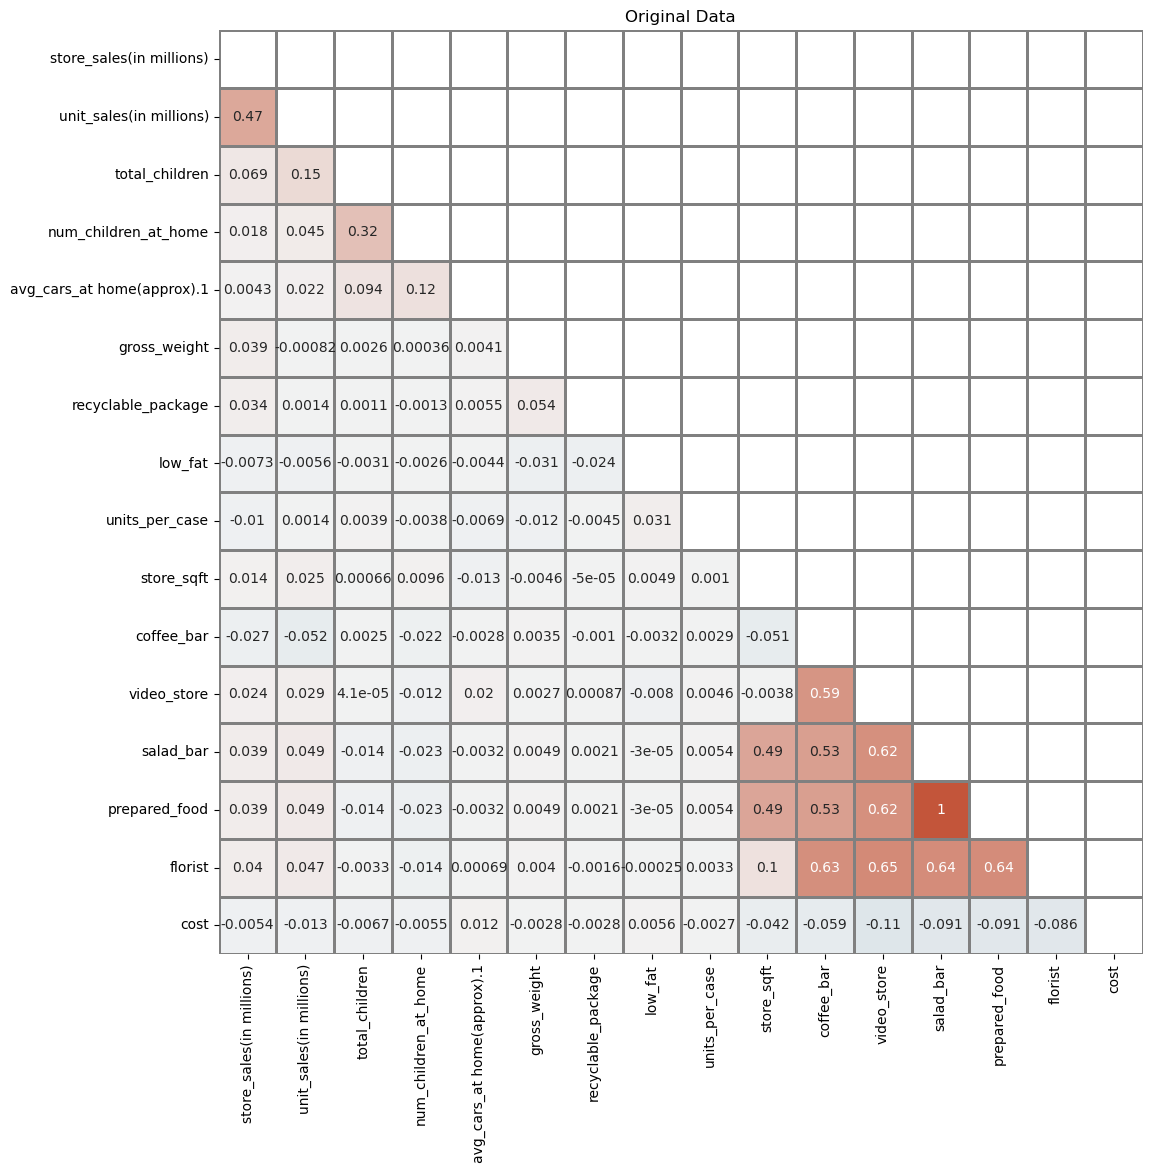

In [18]:
def heatmaps(df,title):
    corr = df.corr(method = 'spearman')
    fig, axes = plt.subplots(figsize = (12,12))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, linecolor = 'gray', linewidths = 2, cmap = sns.diverging_palette(230, 20, as_cmap = True),center = 0, square = True, cbar = False, annot = True)
    plt.title(title)
    plt.show()
heatmaps(train, 'Training Data')
heatmaps(test, 'Test Data')
heatmaps(og, 'Original Data')

In [19]:
## https://www.kaggle.com/code/ravi20076/playgrounds3e11-extensiveeda-ensemble
def fe(df):
    add = pd.DataFrame()
    add['avg_sales'] = df['store_sales(in millions)'] / df['unit_sales(in millions)']
    add['sales_per_unit_width'] = df['unit_sales(in millions)'] / df['gross_weight']
    add['sales_per_area'] = df['store_sales(in millions)'] / df['store_sqft']
    add['gross_wt_per_sales'] = df['gross_weight'] / df['unit_sales(in millions)']
    add['child_ration'] = df['num_children_at_home'] / df['total_children']
    add['child_ration'] = add['child_ration'].fillna(0.0)
    add['facilities'] = df['coffee_bar'] + df['video_share'] + df['salad_bar'] + df['florist'] + df['prepared_food']
    add['area_per_facility'] = np.round(add['facilities'] / df['store_sqft'], 6) * 10 ** 6
    add['area_per_facility'] = add['area_per_facility'].fillna(add['area_per_facility'].mean())
    add['has_car'] = (df['avg_cars_at home(approx).1'] >= 1).astype(np.int8)
    add['has_children'] = (df['total_children'] >=1).astype(np.int8)
    add['child_difference'] = np.clip(df['total_children'] - df['num_children_at_home'], a_min = 0, a_max = np.inf).astype(np.int8)
    return add

In [20]:
x = train_cp.drop(['cost', 'prepared_food'], axis = 1)
# x = pd.concat([x, fe(train)], axis = 1)
y = np.log(train_cp.cost)
# from https://www.kaggle.com/code/shashwatraman/eda-adversarial-validation-and-simple-xgboost/notebook

In [21]:
x.head()

,total_children,num_children_at_home,avg_cars_at home(approx).1,low_fat,store_sqft,coffee_bar,video_store,florist
id,,,,,,,,
0,2.0,2.0,2.0,0.0,36509.0,0.0,0.0,0.0
1,4.0,0.0,3.0,0.0,28206.0,1.0,0.0,0.0
2,0.0,0.0,3.0,0.0,21215.0,1.0,0.0,0.0
3,5.0,0.0,0.0,1.0,21215.0,1.0,0.0,0.0
4,5.0,0.0,3.0,1.0,27694.0,1.0,1.0,1.0


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 50)

In [23]:
test_data = test_cp.drop('prepared_food', axis = 1)
# test_data = pd.concat([test_data, fe(test)], axis = 1)
test_data.head()

,total_children,num_children_at_home,avg_cars_at home(approx).1,low_fat,store_sqft,coffee_bar,video_store,florist
id,,,,,,,,
360336,1.0,0.0,2.0,1.0,20319.0,0.0,0.0,0.0
360337,2.0,2.0,3.0,0.0,33858.0,1.0,0.0,1.0
360338,0.0,0.0,3.0,1.0,39696.0,0.0,0.0,0.0
360339,3.0,3.0,2.0,0.0,23688.0,1.0,1.0,1.0
360340,2.0,0.0,2.0,0.0,27694.0,1.0,1.0,1.0


In [24]:
def normalize_sqft(x):
    max_sqft, min_sqft = x['store_sqft'].max(), x['store_sqft'].min()
    x['store_sqft'] = x['store_sqft'].apply(lambda x: (x - min_sqft) / (max_sqft - min_sqft))
#     max_area, min_area = x['area_per_facility'].max(), x['area_per_facility'].min()
#     x['area_per_facility'] = x['area_per_facility'].apply(lambda x: (x - min_area) / (max_area - min_area))
    return x
x = normalize_sqft(x)
test_data = normalize_sqft(test_data)

In [25]:
x.head()

,total_children,num_children_at_home,avg_cars_at home(approx).1,low_fat,store_sqft,coffee_bar,video_store,florist
id,,,,,,,,
0,2.0,2.0,2.0,0.0,0.835527,0.0,0.0,0.0
1,4.0,0.0,3.0,0.0,0.407029,1.0,0.0,0.0
2,0.0,0.0,3.0,0.0,0.046240,1.0,0.0,0.0
3,5.0,0.0,0.0,1.0,0.046240,1.0,0.0,0.0
4,5.0,0.0,3.0,1.0,0.380606,1.0,1.0,1.0


In [26]:
test_data.head()

,total_children,num_children_at_home,avg_cars_at home(approx).1,low_fat,store_sqft,coffee_bar,video_store,florist
id,,,,,,,,
360336,1.0,0.0,2.0,1.0,0.000000,0.0,0.0,0.0
360337,2.0,2.0,3.0,0.0,0.698715,1.0,0.0,1.0
360338,0.0,0.0,3.0,1.0,1.000000,0.0,0.0,0.0
360339,3.0,3.0,2.0,0.0,0.173866,1.0,1.0,1.0
360340,2.0,0.0,2.0,0.0,0.380606,1.0,1.0,1.0


In [27]:
print(x.shape, y.shape, test_data.shape)

(360336, 8) (360336,) (240224, 8)


In [28]:
FEATURES = x.columns

# HyperParameter Tuning

**Tip From Python Tricks**

- while writing the parameters, always write parameters one in a line so that you won't miss any commas, This may sound silly but I know it happens all the time and the code is interrupted.

In [29]:
xgb_param = {
    'lambda' : 0.0011464259728112235,
    'alpha' : 9.616924031102927,
    'colsample_bytree' : 0.8,
    'subsample' : 0.8,
    'learning_rate' : 0.04,
    'objective' : 'reg:squarederror',
    'max_depth' : 17,
    'random_state' : 42,
    'min_child_weight' : 38,
    'n_estimators' : 10000,
    'tree_method' : 'gpu_hist'
}

lgbm_param = {
    'red_alpha' : 2.6022755655549052,
    'red_lambda' : 0.0073179066032019,
    'colsample_bytree' : 0.8,
    'subsample' : 0.8,
    'learning_rate' : 0.006,
    'max_depth' : 20,
    'num_leaves' : 595,
    'min_child_samples' : 25,
#     'min_data_per_groups' : 63,
    'n_estimators' : 10000,
#     'tree_method' : 'gpu_hist'
}

cat_param = {
    'iterations' : 10000,
    'depth' : 7,
    'learning_rate' : 0.04,
    'l2_leaf_reg' : 0.6169164517797081,
    'random_strength' : 0.21235850198764036,
    'max_bin' : 212,
    'od_wait' : 67,
    'one_hot_max_size' : 73,
    'grow_policy' : 'Depthwise',
    'bootstrap_type' : 'Bayesian',
    'od_type' : 'Iter',
    'loss_function' : 'RMSE',
    'random_state' : 42
}

In [30]:
# preds = list()
# kf = KFold(n_splits = 5, random_state = 48, shuffle = True)
# rmsle = [] #list contains rmse for each fold
# n = 0
# for trn_idx, test_idx in kf.split(x,y):
#     x_tr, x_val = x.iloc[trn_idx], x.iloc[test_idx]
#     y_tr, y_val = y.iloc[trn_idx], y.iloc[test_idx]
#     model = XGBRegressor(**xgb_param)
#     model.fit(x_tr, y_tr, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = False)
#     preds.append(np.exp(model.predict(test_data)))
#     rmsle.append(mean_squared_log_error(y_val, model.predict(x_val), squared = False))
#     print(f"fold: {n + 1} ==> rmsle: {rmsle[n]}")
#     n += 1

In [31]:
# xgb_pred = np.mean(preds, axis = 0)
# xgb_pred

In [32]:
preds = list()
kf = KFold(n_splits=5,random_state=48,shuffle=True)
rmsle=[]  # list contains rmse for each fold
n=0
for trn_idx, test_idx in kf.split(x,y):
    X_tr,X_val=x.iloc[trn_idx],x.iloc[test_idx]
    y_tr,y_val=y.iloc[trn_idx],y.iloc[test_idx]
    model = LGBMRegressor(**lgbm_param)
    model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ])
    preds.append(np.exp(model.predict(test_data)))
    rmsle.append(mean_squared_log_error(y_val, model.predict(X_val), squared=False))
    print(f"fold: {n+1} ==> rmsle: {rmsle[n]}")
    n+=1

[LightGBM] [Warning] Unknown parameter: red_alpha
[LightGBM] [Warning] Unknown parameter: red_lambda
fold: 1 ==> rmsle: 0.05406862892126879
[LightGBM] [Warning] Unknown parameter: red_alpha
[LightGBM] [Warning] Unknown parameter: red_lambda
fold: 2 ==> rmsle: 0.054185843736958506
[LightGBM] [Warning] Unknown parameter: red_alpha
[LightGBM] [Warning] Unknown parameter: red_lambda
fold: 3 ==> rmsle: 0.054169461085139106
[LightGBM] [Warning] Unknown parameter: red_alpha
[LightGBM] [Warning] Unknown parameter: red_lambda
fold: 4 ==> rmsle: 0.0541833627797956
[LightGBM] [Warning] Unknown parameter: red_alpha
[LightGBM] [Warning] Unknown parameter: red_lambda
fold: 5 ==> rmsle: 0.05419668476492299


In [33]:
lgbm_pred = np.mean(preds, axis = 0)

In [34]:
# preds = list()
# kf = KFold(n_splits = 5, random_state = 48, shuffle = True)
# rmsle = [] #list contains rmse for each fold
# n = 0
# for trn_idx, test_idx in kf.split(x,y):
#     x_tr, x_val = x.iloc[trn_idx], x.iloc[test_idx]
#     y_tr, y_val = y.iloc[trn_idx], y.iloc[test_idx]
#     model = CatBoostRegressor(**cat_param)
#     model.fit(x_tr, y_tr, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = False)
#     preds.append(np.exp(model.predict(test_data)))
#     rmsle.append(mean_squared_log_error(y_val, model.predict(x_val), squared = False))
#     print(f"fold: {n + 1} ==> rmsle: {rmsle[n]}")
#     n += 1

In [35]:
# cat_pred = np.mean(preds, axis = 0)

In [36]:
# final = xgb_pred * 0.2 + lgbm * 0.7 + cat_pred * 0.1
submission['cost'] = lgbm_pred
submission.to_csv('PSS3E11.csv', index = None)

In [37]:
submission.head()

,id,cost
0,360336,91.795590
1,360337,92.988502
2,360338,93.899182
3,360339,97.192121
4,360340,76.992020
